In [1]:
from imports import *
from data_generator import *
from models import *

#shouldn't need on a local computer?
from utils import limit_mem

#Module to save and load models
import h5py
import netCDF4
import numpy as np

from keras.models import Sequential
from keras.layers import *
import time
#added by Griffin
import xarray as xr


from tensorflow.python.ops.parallel_for.gradients import batch_jacobian
from tensorflow.python.ops.parallel_for.gradients import jacobian

Using TensorFlow backend.


In [2]:
output_vector = 65
input_vector = 64
print('Starting')


#If running on the GPU or GPU-shared partition uncomment
limit_mem()


DATADIR = '/DFS-L/DATA/pritchard/gmooers/RG_Paper/RG_DATA/Preprocessed_Data/One_Month_July/'



valid_gen = DataGenerator(
    data_dir=DATADIR, 
    feature_fn='full_physics_essentials_valid_month02_features.nc',
    target_fn='full_physics_essentials_valid_month02_targets.nc',
    batch_size=512,
    norm_fn='full_physics_essentials_train_month01_norm.nc',  # SAME NORMALIZATION FILE!
    fsub='feature_means', 
    fdiv='feature_stds', 
    tmult='target_conv',
    shuffle=False,
)


fsub = valid_gen.feature_norms[0]
fdiv = valid_gen.feature_norms[1]
tsub = valid_gen.target_norms[0]
tdiv = valid_gen.target_norms[1]


model = tf.keras.models.load_model('/fast/gmooers/Models/ContinentModels/second_round_model.h5')

path_to_file = '/DFS-L/DATA/pritchard/gmooers/RG_Paper/RG_DATA/Preprocessed_Data/One_Month_July/full_physics_essentials_valid_month02_features.nc'
real_ds = xr.open_dataset(path_to_file)
features = real_ds.features[:, :].values
print(features.shape)


path_to_file = '/DFS-L/DATA/pritchard/gmooers/RG_Paper/RG_DATA/Preprocessed_Data/One_Month_July/full_physics_essentials_valid_month02_targets.nc'
real_ds = xr.open_dataset(path_to_file)
targets = real_ds.targets[:, :].values

Starting


Generator will have 41126400 samples in 80325 batches
Features have shape 64; targets have shape 65
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
(41126400, 64)


In [3]:
sess = tf.InteractiveSession()
sess.run(tf.initialize_all_variables())

Instructions for updating:
Use `tf.global_variables_initializer` instead.


In [27]:
def jacobian_tensorflow(x, my_model, target_length):    
    jacobian_matrix = []
    for m in range(target_length):
        print(m)
        grad_func = tf.gradients(my_model.output[:, m], my_model.input)
        gradients = sess.run(grad_func, feed_dict={my_model.input: (x.reshape((1, x.size))-fsub)/fdiv})
        jacobian_matrix.append((gradients[0][0,:]/tdiv[m])+tsub)
    return np.array(jacobian_matrix)

In [ ]:
jacob_matrix = jacobian_tensorflow(features[0], model, output_vector)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


In [ ]:
print(jacob_matrix.shape)

Need to normalize to growth units (1/s)

input vector: [TBP, QBP, PS, SOLIN, SHFLX, LHFLX]

output vector: [PTTEND, PTEQ, FSNT, FSNS, FLNT, FLNS, PRECT]



In [20]:
Cp = 1.00464e3
Lv = 2.50e6
dt = 3600.0
Normalized_Jacobian = np.empty(jacob_matrix.shape)

In [21]:
Normalized_Jacobian.shape

(65, 64)

In [22]:
for i in range(len(jacob_matrix)):
    for j in range(len(jacob_matrix[i])):
        if i < 30:
            if j < 30:
                Normalized_Jacobian[i,j] = jacob_matrix[i,j]
            if j >=30 and j < 60:
                Normalized_Jacobian[i,j] = jacob_matrix[i,j]*Lv/Cp
            if j >= 60:
                Normalized_Jacobian[i,j] = jacob_matrix[i,j]*dt/Cp
                
        if i >=30 and i < 60:
            if j < 30:
                Normalized_Jacobian[i,j] = jacob_matrix[i,j]*Cp/Lv
            if j >=30 and j < 60:
                Normalized_Jacobian[i,j] = jacob_matrix[i,j]
            if j >= 60:
                Normalized_Jacobian[i,j] = jacob_matrix[i,j]*dt/Lv
                
        if i>=60:
            if j < 30:
                Normalized_Jacobian[i,j] = jacob_matrix[i,j]*Cp/dt
            if j >=30 and j < 60:
                Normalized_Jacobian[i,j] = jacob_matrix[i,j]*Lv/dt
            if j >= 60 and j<64:
                Normalized_Jacobian[i,j] = jacob_matrix[i,j]
                
            
        
                
                

In [23]:
import matplotlib
import matplotlib.pyplot as plt
fz = 15*1.5
lw = 4
siz = 100
XNNA = 1.25 # Abscissa where architecture-constrained network will be placed
XTEXT = 0.25 # Text placement
YTEXT = 0.3 # Text placement

plt.rc('text', usetex=False)
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
#mpl.rcParams["font.serif"] = "STIX"
plt.rc('font', family='serif', size=fz)
matplotlib.rcParams['lines.linewidth'] = lw

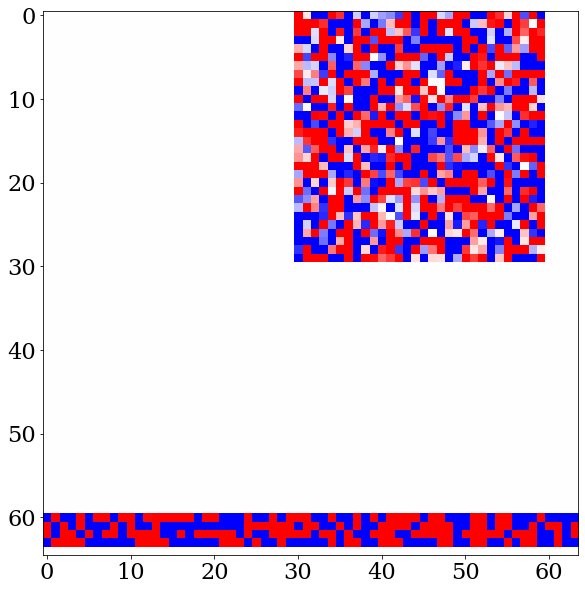

In [25]:

fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(Normalized_Jacobian, vmin=-0.01, vmax=0.01, cmap='bwr')

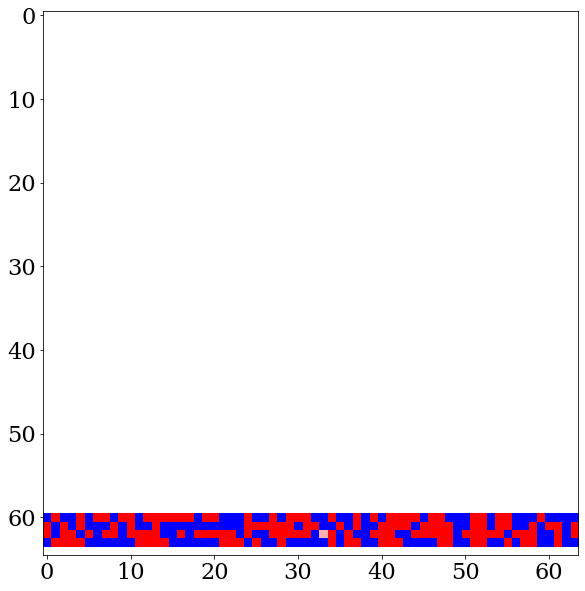

In [26]:

fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(jacob_matrix, vmin=-0.01, vmax=0.01, cmap='bwr')

In [34]:
def jacobian_day(feature_data, my_model, target_length, feature_length, num_days):
    jacobians = np.zeros(shape=(num_days, target_length, feature_length))
    for i in range(num_days):
        print(i)
        jacob_matrix = jacobian_tensorflow(feature_data[i], my_model, target_length)
        jacobians[i,:,:] = jacob_matrix
    
    np.save("/fast/gmooers/Raw_Data/Day_Jacobian.npy", jacobians)
    return jacobians

In [35]:
#jacobians = jacobian_day(features, model, output_vector, input_vector, 96)
print("made it")

0
1


KeyboardInterrupt: 